# Comparison between the Analytical and the Learning-based approach

## Imports and constants

In [370]:
import math
import os

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft
from sklearn.metrics import confusion_matrix, accuracy_score

from itertools import combinations

SAMPLES = 2048
STEP = 1024

AUDIO_PATH = 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\full_circle\\0.001\\test_angle_280_dist_200_room_medium_arctic_a0200.wav'

## Utils

In [371]:
fs, wav_signals = wavfile.read(AUDIO_PATH)
grid = 360

## Functions

In [372]:
# MUSIC
# Calculate Short-time Fourier transform and return
overlap = 256 // 2
fft = 256

observation = stft.analysis(wav_signals, L=fft, hop=overlap)
X = np.transpose(observation, axes=[2, 1, 0])

mic_pos=np.c_[[7/2+0.1, 0, 0],[7/2-0.1, 0, 0]] 
doa = pra.doa.MUSIC(mic_pos, fs, nfft=fft, n_grid=(grid // 10), num_src=1)
doa.locate_sources(X)
pred = doa.azimuth_recon[0] 

spatial_resp = doa.grid.values
min_val = spatial_resp.min()
max_val = spatial_resp.max()
spatial_resp = (spatial_resp - min_val) / (max_val - min_val)
phi_plt = doa.grid.azimuth / 2
c_phi_plt = np.r_[phi_plt, phi_plt[0]]
c_dirty_img = np.r_[spatial_resp, spatial_resp[0]]

In [373]:
# CNN
CNN = pd.read_csv('../comparison/CNN_spectrum.csv')
data = np.array([])

for i in range(len(CNN)):
    if CNN.loc[i, 'y_true'] == 280:
        data = np.append(data, CNN['y_pred'][i])

# Get the spectrum
angle_pp = list(range(0, grid + 1, 10))
instance = np.array([])
CNN_spectrum = np.array([])

for angle in angle_pp:
    instance = np.append(instance, np.count_nonzero(data == angle))

min_val = np.min(instance)
max_val = np.max(instance)
norm_array = (instance - min_val) / (max_val - min_val)

## Visualize comparison

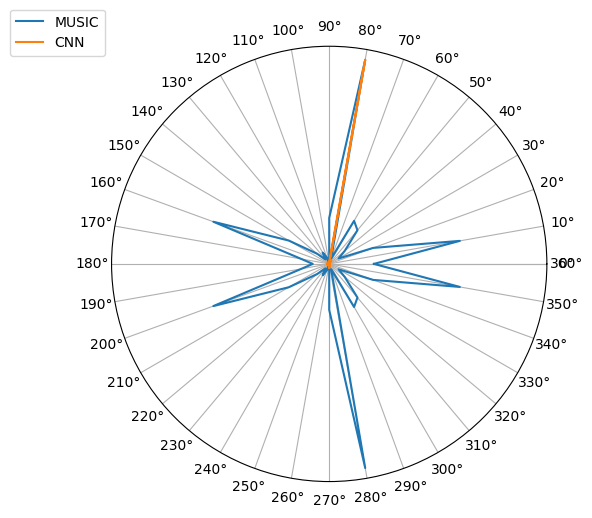

In [374]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(polar=True)

# Set the theta values from 0 to pi
theta = np.linspace(0, (grid*np.pi/180), num=37)

# Plot the circle
ax.plot(theta, c_dirty_img, label='MUSIC')
ax.plot(theta, norm_array, label='CNN')

# Set the labels and title of the plot
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_thetagrids(range(0, grid + 1, 10)) # set the gridlines
ax.set_rticks([])

# Add a legend
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0, ncol=1, bbox_to_anchor=(0, 1.1))

plt.show()

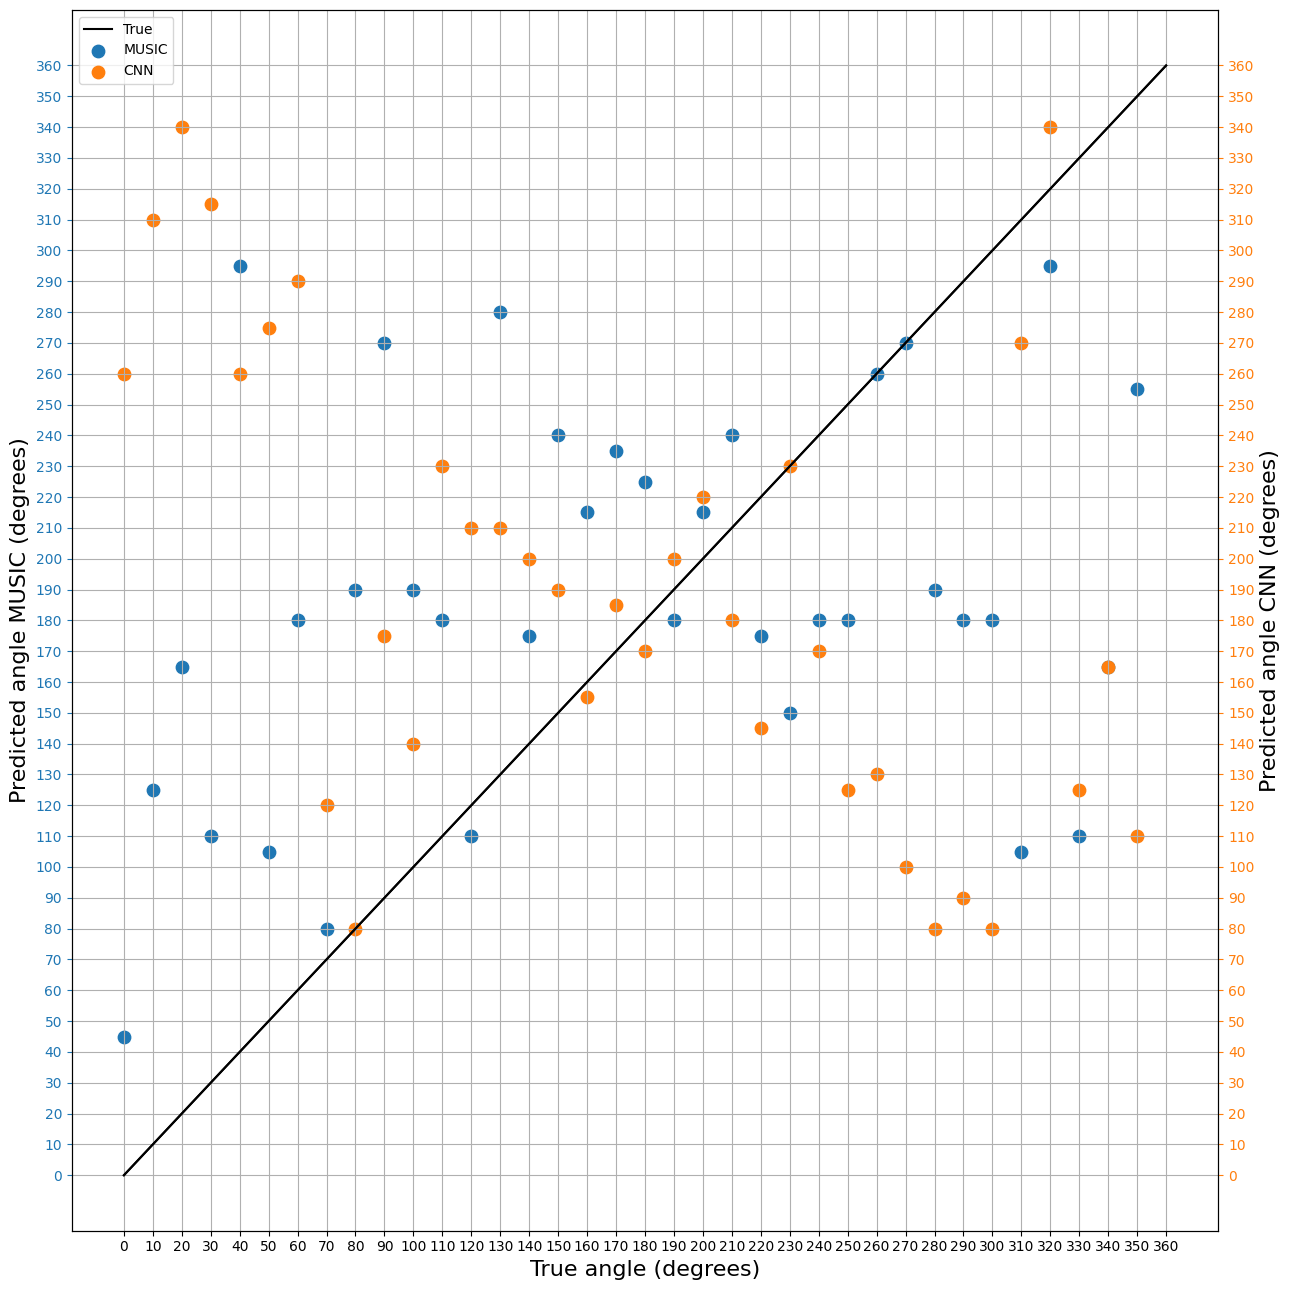

In [306]:
# Generate data for the x-axis
x = list(range(0, grid + 1, 10))

# Generate data for the y-axes
MUSIC = pd.read_csv('../comparison/MUSIC_data.csv')
CNN = pd.read_csv('../comparison/CNN_data.csv')

# Create the figure and subplots
fig, ax1 = plt.subplots(figsize=(13, 13))

# Create a second y-axis on the right side
ax2 = ax1.twinx()

# Plot the data on each axis
ax1.plot(x, x, color='black', label='True')
ax2.plot(x, x, color='black')
MUSIC.plot.scatter(x="y_true", y="y_pred", ax=ax1, s=80, color='C0', label='MUSIC')
CNN.plot.scatter(x="y_true", y="y_pred", ax=ax1, s=80, color='C1', label='CNN')

# Set the limits and labels for each axis
ax1.set_xticks(list(range(0, grid + 1, 10)))
ax1.set_yticks(list(range(0, grid + 1, 10)))
ax2.set_yticks(list(range(0, grid + 1, 10)))

ax1.set_xlabel('True angle (degrees)', fontsize=16)
ax1.set_ylabel('Predicted angle MUSIC (degrees)', fontsize=16)
ax2.set_ylabel('Predicted angle CNN (degrees)', fontsize=16)

ax1.tick_params(axis='y', colors='C0')
ax2.tick_params(axis='y', colors='C1')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', ncol=1)

# Add a grid
ax1.grid(True)

# Display the plot
plt.show()